In [1]:
try:
    !pip install spacy
    import json
    import os
    
    import pandas as  pd
    import spacy
    
    import seaborn as sns
    import string

    from tqdm import tqdm
    from textblob import TextBlob
    
    from nltk.corpus import stopwords
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize
    import re
    
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    
    
    from sklearn.preprocessing import FunctionTransformer
    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.pipeline import FeatureUnion
    from sklearn.feature_extraction import DictVectorizer
    
    import swifter
    
    tqdm.pandas()
except Exception as e:
    print("Error : {} ".format(e))

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_excel("dataset.xlsx")

In [3]:
df.head(10)



,categories,mssg
0,fund transfer,965439 is the OTP for transaction of INR 87650...
1,fund transfer,5465 is the OTP for transaction of INR 450 at ...
2,Login otp,"Dear customer , use this One Time Password 854..."
3,Login otp,"Dear customer , use this One Time Password 458..."
4,Login otp,"Dear customer , use this One Time Password 453..."
5,Password reset OTPs,"Dear customer , the one time password OTP to r..."
6,Password reset OTPs,"Dear customer , the one time password OTP to r..."
7,Password reset OTPs,"Dear customer , the one time password OTP to r..."
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


<AxesSubplot:>

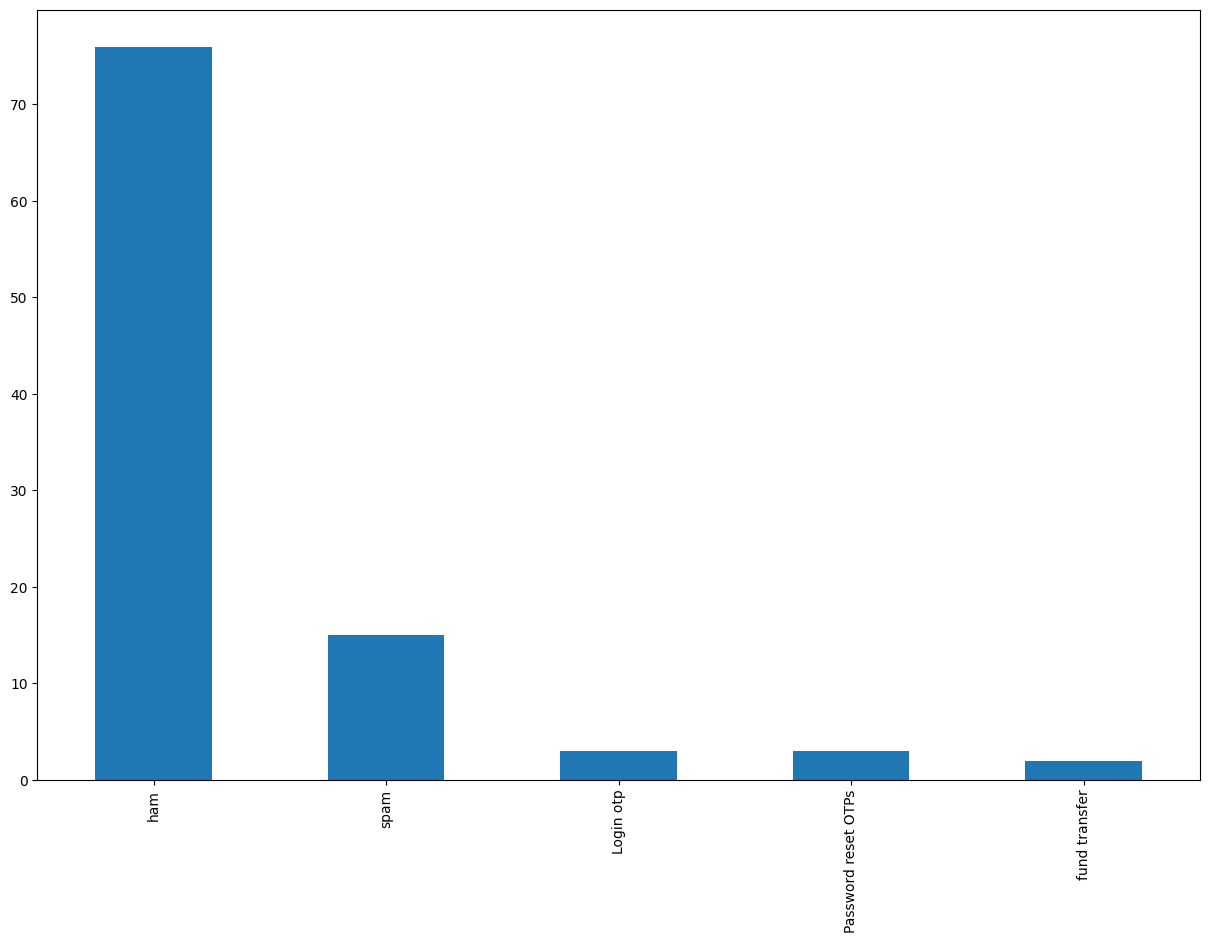

In [4]:
df['categories'].value_counts().plot( kind='bar', figsize=(15,10))

In [5]:
df.columns

Index(['categories', 'mssg'], dtype='object')

In [6]:
df.describe()

,categories,mssg
count,99,99
unique,5,99
top,ham,965439 is the OTP for transaction of INR 87650...
freq,76,1


In [7]:
df.isna().sum()

categories    0
mssg          0
dtype: int64

In [8]:
df['categories'].unique()

array(['fund transfer', 'Login otp', 'Password reset OTPs', 'spam', 'ham'],
      dtype=object)

In [9]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()
my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [10]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

def polarity_txt(text):
    return TextBlob(text).sentiment[0]

def len_text(text):
    if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
    else:
         return 0

In [13]:
df['text'] = df['mssg']

df['text'] = df['text'].swifter.apply(clean_txt)
df['polarity'] = df['text'].swifter.apply(polarity_txt)
df['subjectivity'] = df['text'].swifter.apply(subj_txt)
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

In [14]:
X = df[['text', 'polarity', 'subjectivity','len']]
y =df['categories']
encoder = LabelEncoder()
y = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
v = dict(zip(list(y), df['categories'].to_list()))

In [15]:
text_clf = Pipeline([
...     ('vect', CountVectorizer(analyzer="word", stop_words="english")),
...     ('tfidf', TfidfTransformer(use_idf=True)),
...     ('clf', MultinomialNB(alpha=.01)),
... ])

In [16]:
text_clf.fit(x_train['text'].to_list(), list(y_train))

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

In [17]:
import numpy as np

In [18]:
X_TEST = x_test['text'].to_list()
Y_TEST = list(y_test)

In [19]:
predicted = text_clf.predict(X_TEST)

In [20]:
np.mean(predicted == Y_TEST)

0.9

In [36]:
docs_new = ['478569 is otp for login your instagram']

In [37]:
predicted = text_clf.predict(docs_new)

In [38]:
v[predicted[0]]

'Login otp'